In [1]:
import os
from oads_access.oads_access import OADS_Access, OADSImageDataset
from torch.utils.data import random_split, DataLoader, Subset
from pytorch_utils.pytorch_utils import collate_fn
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
oads_dir = '/home/Public/Datasets/oads'
imagenet_dir = '/home/Public/Datasets/Imagenet'

In [3]:
oads = OADS_Access(basedir=oads_dir, n_processes=4)

use_crops = True
img_size = (400, 400)
batch_size = 4

device = 'cuda'

mean_oads = [0.3410, 0.3123, 0.2787]
std_oads = [0.2362, 0.2252, 0.2162]

# Get the custom dataset and dataloader
print(f"Getting data loaders")
transform_list_oads = []
transform_list_oads.append(transforms.Resize(tuple(img_size)))
# print(img_size)

# Apply color opponnent channel representation
# if image_representation == 'coc' or image_representation == 'COC':
#     transform_list_oads.append(ToOpponentChannel())

# # Compute edge map and use as input instead
# if image_representation == 'RGBEdges':
#     threshold_lgn_path = f'{os.path.expanduser("~")}/projects/lgnpy/ThresholdLGN.mat'
#     default_config_path = f'{os.path.expanduser("~")}/projects/lgnpy/lgnpy/CEandSC/default_config.yml'
#     threshold_lgn = loadmat(threshold_lgn_path)['ThresholdLGN']
#     transform_list_oads.append(ToRGBEdges(threshold_lgn=threshold_lgn, default_config_path=default_config_path))

# transform_list_oads.append(transforms.ToTensor())
# transform_list_oads.append(transforms.Normalize(mean_oads, std_oads))

transform_oads = transforms.Compose(transform_list_oads)

class_index_mapping = {}
index_label_mapping = {}
for index, (key, item) in enumerate(list(oads.get_class_mapping().items())):
    class_index_mapping[key] = index
    index_label_mapping[index] = item

oads_train_ids, oads_val_ids, oads_test_ids = oads.get_train_val_test_split_indices(use_crops=use_crops)

train_dataset_oads = OADSImageDataset(oads_access=oads, item_ids=oads_train_ids, use_crops=use_crops,
                            class_index_mapping=class_index_mapping, transform=transform_oads, device=device)
val_dataset_oads = OADSImageDataset(oads_access=oads, item_ids=oads_val_ids, use_crops=use_crops,
                                class_index_mapping=class_index_mapping, transform=transform_oads, device=device)
test_dataset_oads = OADSImageDataset(oads_access=oads, item_ids=oads_test_ids, use_crops=use_crops,
                            class_index_mapping=class_index_mapping, transform=transform_oads, device=device)


train_dataloader_oads = DataLoader(train_dataset_oads, collate_fn=collate_fn,
                            batch_size=batch_size, shuffle=True, num_workers=oads.n_processes)

Getting data loaders


In [4]:
mean_imagenet = [0.485, 0.456, 0.406]
std_imagenet = [0.229, 0.224, 0.225]

transform_list = []
# transform_list.append(transforms.RandomHorizontalFlip())
# transform_list.append(transforms.GaussianBlur(kernel_size=3))
# transform_list.append(transforms.ColorJitter())
transform_list.append(transforms.Resize(256))
transform_list.append(transforms.CenterCrop(224))
# if image_representation == 'coc' or image_representation == 'COC':
#     transform_list.append(ToOpponentChannel())
# transform_list.append(transforms.ToTensor())
# transform_list.append(transforms.Normalize(mean_imagenet, std_imagenet))
transform_imagenet = transforms.Compose(transform_list)
imagenet = ImageFolder(root=os.path.join(imagenet_dir, 'train'), transform=transform_imagenet)
train_dataset_imagenet, test_dataset_imagenet  = random_split(imagenet, [1153051, 128116])
val_dataset_imagenet = ImageFolder(root=os.path.join(imagenet_dir, 'val'), transform=transform_imagenet)

train_dataloader_imagenet = DataLoader(
            train_dataset_imagenet,
            batch_size=batch_size,
            shuffle=True,
            num_workers=oads.n_processes,
            pin_memory=True,
            drop_last=True,
        )

# Example Image

In [44]:
oads_img, oads_label = oads.load_image(list(oads.image_names.keys())[0])
# oads_img = oads_img.reduce(10)
oads_img = oads_img.crop((5496//2,3672//2, 5496//2 + 500, 3672//2 + 333))
oads_img = oads_img.resize((224, 224))

In [47]:
# imagenet_img = next(iter(train_dataloader_imagenet))[0]
folder = os.listdir(os.path.join(imagenet_dir, 'val'))[0]
imagenet_img_name = os.listdir(os.path.join(imagenet_dir, 'val', folder))[0]
imagenet_img = Image.open(os.path.join(imagenet_dir, 'val', folder, imagenet_img_name))
imagenet_img = imagenet_img.resize((224, 224))

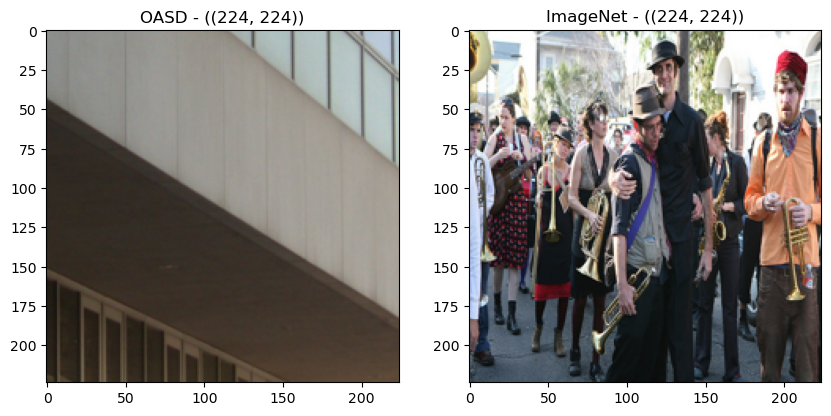

In [48]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(oads_img)
ax[1].imshow(imagenet_img)

ax[0].set_title(f'OASD - ({oads_img.size})')
ax[1].set_title(f'ImageNet - ({imagenet_img.size})')

plt.show()

In [8]:
# n_images = 10

# fig, ax = plt.subplots(n_images,2, figsize=(10,5*n_images))

# for index in range(n_images):
#     oads_img, oads_label = oads.load_image(list(oads.image_names.keys())[index])

#     folder = os.listdir(os.path.join(imagenet_dir, 'val'))[0]
#     imagenet_img_name = os.listdir(os.path.join(imagenet_dir, 'val', folder))[index]
#     imagenet_img = Image.open(os.path.join(imagenet_dir, 'val', folder, imagenet_img_name))

    
#     ax[index, 0].imshow(oads_img)
#     ax[index, 1].imshow(imagenet_img)

# plt.show()

## Add Noise

In [49]:
import numpy as np

In [50]:
rng = np.random.default_rng()

In [51]:
noise = rng.integers(low=0, high=255, size=np.array(oads_img).shape)

In [52]:
imagenet_noise = noise[:np.array(imagenet_img).shape[0], :np.array(imagenet_img).shape[1]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


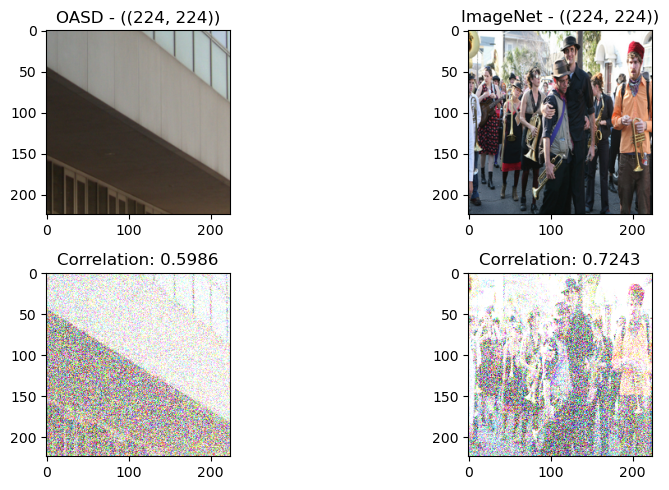

In [53]:
fig, ax = plt.subplots(2,2, figsize=(10,5))

ax[0, 0].imshow(oads_img)
ax[0, 1].imshow(imagenet_img)

oads_noise_img = oads_img + noise
imagenet_noise_img = imagenet_img + imagenet_noise

ax[1, 0].imshow(oads_noise_img)
ax[1, 1].imshow(imagenet_noise_img)

ax[0, 0].set_title(f'OASD - ({oads_img.size})')
ax[0, 1].set_title(f'ImageNet - ({imagenet_img.size})')

# Correlate

oads_corr = np.corrcoef(np.array(oads_img).flatten(), np.array(oads_noise_img).flatten())[0,1]
imagenet_corr = np.corrcoef(np.array(imagenet_img).flatten(), np.array(imagenet_noise_img).flatten())[0,1]

ax[1, 0].set_title(f'Correlation: {oads_corr:.4f}')
ax[1, 1].set_title(f'Correlation: {imagenet_corr:.4f}')

plt.tight_layout()
plt.show()

## Get Edge maps

In [14]:
from lgnpy.CEandSC.lgn_statistics import get_edge_maps, LGN
from oads_access.utils import loadmat

In [54]:
threshold_lgn_path = f'{os.path.expanduser("~")}/projects/lgnpy/ThresholdLGN.mat'
default_config_path = f'{os.path.expanduser("~")}/projects/lgnpy/lgnpy/CEandSC/default_config.yml'
threshold_lgn = loadmat(threshold_lgn_path)['ThresholdLGN']

lgn = LGN(config={}, default_config_path=default_config_path)

Could not load mat file with mat73 - trying to load with scipy.io.loadmat!


In [55]:
oads_edge_map = get_edge_maps(im=np.array(oads_img), cache=False, file_name='', force_recompute=True, imsize=np.array(oads_img).shape[:2], threshold_lgn=threshold_lgn, lgn=lgn, IMTYPE=2)

In [56]:
oads_noise_edge_map = get_edge_maps(im=np.array(oads_noise_img), cache=False, file_name='', force_recompute=True, imsize=np.array(oads_noise_img).shape[:2], threshold_lgn=threshold_lgn, lgn=lgn, IMTYPE=2)

In [57]:
imagenet_noise_edge_map = get_edge_maps(im=np.array(imagenet_noise_img), cache=False, file_name='', force_recompute=True, imsize=np.array(imagenet_noise_img).shape[:2], threshold_lgn=threshold_lgn, lgn=lgn, IMTYPE=2)

In [58]:
imagenet_edge_map = get_edge_maps(im=np.array(imagenet_img), cache=False, file_name='', force_recompute=True, imsize=np.array(imagenet_img).shape[:2], threshold_lgn=threshold_lgn, lgn=lgn, IMTYPE=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


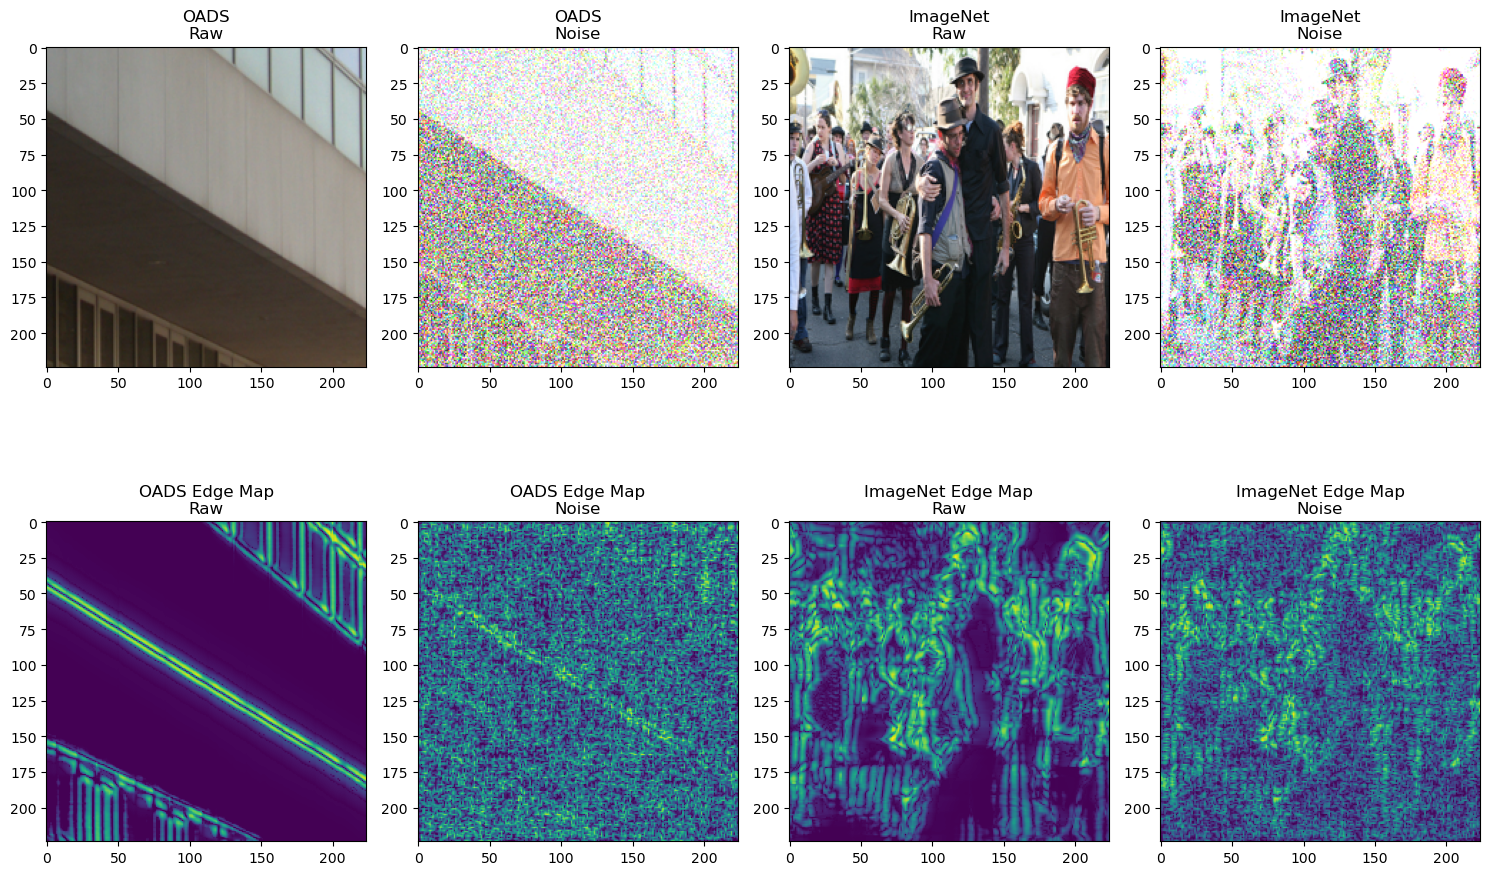

In [59]:
fig, ax = plt.subplots(2,4, figsize=(15,10))

ax[0, 0].imshow(oads_img)
ax[0, 1].imshow(oads_noise_img)
ax[0, 2].imshow(imagenet_img)
ax[0, 3].imshow(imagenet_noise_img)

ax[1, 0].imshow(oads_edge_map[0])
ax[1, 1].imshow(oads_noise_edge_map[0])
ax[1, 2].imshow(imagenet_edge_map[0])
ax[1, 3].imshow(imagenet_noise_edge_map[0])

# Correlation
# OADS 
oads_corr = np.corrcoef(np.array(oads_img)[:,:,0], oads_edge_map[0])[0,1]
oads_corr_noise = np.corrcoef(np.array(oads_noise_img)[:,:,0], oads_noise_edge_map[0])[0,1]

imagenet_corr = np.corrcoef(np.array(imagenet_img)[:,:,0], imagenet_edge_map[0])[0,1]
imagenet_corr_noise = np.corrcoef(np.array(imagenet_noise_img)[:,:,0], imagenet_noise_edge_map[0])[0,1]

ax[0, 0].set_title('OADS\nRaw')
ax[0, 1].set_title('OADS\nNoise')
ax[0, 2].set_title('ImageNet\nRaw')
ax[0, 3].set_title('ImageNet\nNoise')
ax[1, 0].set_title('OADS Edge Map\nRaw')
ax[1, 1].set_title('OADS Edge Map\nNoise')
ax[1, 2].set_title('ImageNet Edge Map\nRaw')
ax[1, 3].set_title('ImageNet Edge Map\nNoise')

# ax[1, 0].set_title(f'Corr: {oads_corr:.4f}')
# ax[1, 1].set_title(f'Corr: {oads_corr_noise:.4f}')
# ax[1, 2].set_title(f'Corr: {imagenet_corr:.4f}')
# ax[1, 3].set_title(f'Corr: {imagenet_corr_noise:.4f}')

plt.tight_layout()
plt.show()

# Multiple

In [171]:
import tqdm

In [190]:
n_images = 50

In [191]:
# Random images
oads_all_image_names = list(oads.image_names.keys())
oads_image_names = np.random.choice(oads_all_image_names, size=n_images)
oads_image_names = [os.path.join(oads_dir, 'oads_arw/tiff', f'{x}.tiff') for x in oads_image_names]

In [192]:
imagenet_all_image_names = []

for folder in os.listdir(os.path.join(imagenet_dir, 'val')):
    for imagenet_img_name in os.listdir(os.path.join(imagenet_dir, 'val', folder)):
        imagenet_all_image_names.append(f"{folder}/{imagenet_img_name}")
imagenet_image_names = np.random.choice(imagenet_all_image_names, size=n_images)
imagenet_image_names = [os.path.join(imagenet_dir, 'val', x) for x in imagenet_image_names if np.array(Image.open(os.path.join(imagenet_dir, 'val', x))).shape[-1] == 3]

In [193]:
image_names = {'oads': oads_image_names, 'imagenet': imagenet_image_names}

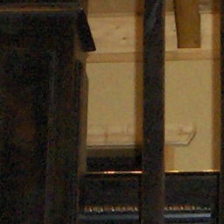

In [198]:
transforms.Resize(224)(transforms.CenterCrop(256)(raw_image))

In [199]:
rng = np.random.default_rng()

correlations = {}
with tqdm.tqdm(total=n_images*2) as bar:
    for dataset in ['imagenet', 'oads']:
        correlations[dataset] = {'raw': [], 'noise': []}


        for index in range(n_images):
            raw_image = Image.open(image_names[dataset][index])
            if dataset == 'oads':
                raw_image = raw_image.reduce(2)
            transforms.Resize(224)(transforms.CenterCrop(256)(raw_image))

            noise = rng.integers(low=0, high=255, size=np.array(raw_image).shape)
            noise_image = raw_image + noise

            # print(np.array(raw_image).shape)
            
            # for condition in ['raw', 'noise']:
            raw_edge_map = get_edge_maps(im=np.array(raw_image), cache=False, file_name='', force_recompute=True, imsize=np.array(raw_image).shape[:2], threshold_lgn=threshold_lgn, lgn=lgn, IMTYPE=2)
            noise_edge_map = get_edge_maps(im=np.array(noise_image), cache=False, file_name='', force_recompute=True, imsize=np.array(noise_image).shape[:2], threshold_lgn=threshold_lgn, lgn=lgn, IMTYPE=2)

            raw_corr = np.corrcoef(np.array(raw_image)[:,:,0].flatten(), raw_edge_map[0].flatten())[0,1]
            noise_corr = np.corrcoef(np.array(noise_image)[:,:,0].flatten(), noise_edge_map[0].flatten())[0,1]

            correlations[dataset]['raw'].append(raw_corr)
            correlations[dataset]['noise'].append(noise_corr)

            bar.update(1)

 61%|██████    | 61/100 [14:01<08:57, 13.79s/it]


KeyboardInterrupt: 

In [200]:
from sklearn.linear_model import LinearRegression

In [206]:
np.array(oads_correlations_raw).reshape(len(oads_correlations_raw), 1)

array([[0.33636364],
       [0.2308368 ],
       [0.23654191],
       [0.28962896],
       [0.38959342],
       [0.38522448],
       [0.31000538],
       [0.35712364],
       [0.13495324],
       [0.23170865],
       [0.18231181]])

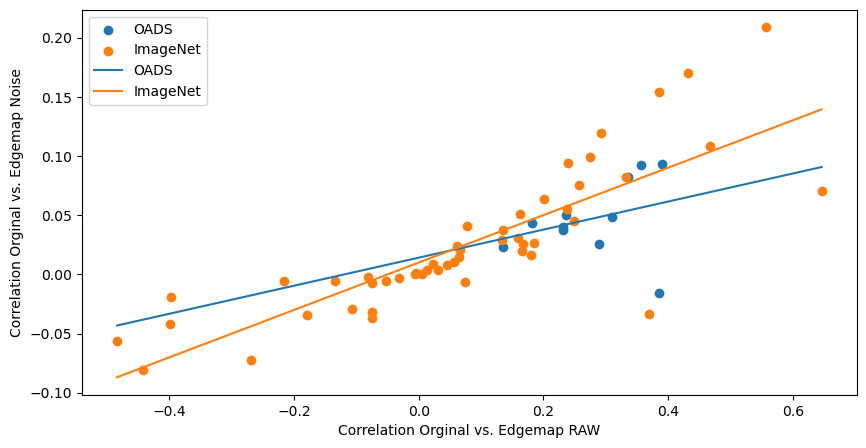

In [216]:
# plot 

oads_correlations_raw = correlations['oads']['raw']
oads_correlations_noise = correlations['oads']['noise']
imagenet_correlations_raw = correlations['imagenet']['raw']
imagenet_correlations_noise = correlations['imagenet']['noise']

fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.scatter(oads_correlations_raw, oads_correlations_noise, label='OADS')
ax.scatter(imagenet_correlations_raw, imagenet_correlations_noise, label='ImageNet')

ax.set_xlabel('Correlation Orginal vs. Edgemap RAW')
ax.set_ylabel('Correlation Orginal vs. Edgemap Noise')


# regression line
x = list(np.linspace(min(min(oads_correlations_raw), min(imagenet_correlations_raw)), max(max(oads_correlations_raw), max(imagenet_correlations_raw))))

lin_reg_oads = LinearRegression().fit(X=np.array(oads_correlations_raw).reshape(len(oads_correlations_raw), 1), y=oads_correlations_noise)
slope_oads, intercept_oads = lin_reg_oads.coef_, lin_reg_oads.intercept_
ax.plot(x, [slope_oads * x[i] + intercept_oads for i in range(len(x))], label='OADS')

lin_reg_imagenet = LinearRegression().fit(X=np.array(imagenet_correlations_raw).reshape(len(imagenet_correlations_raw), 1), y=imagenet_correlations_noise)
slope_imagenet, intercept_imagenet = lin_reg_imagenet.coef_, lin_reg_imagenet.intercept_
ax.plot(x, [slope_imagenet * x[i] + intercept_imagenet for i in range(len(x))], label='ImageNet')


ax.legend()
plt.show()